In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud
import nltk
import numpy as np

## RECOMENDATION SYSTEM TO FIND POTENTIAL GOOD CUSTOMERS IN PHOENIX

During this notebook, the target user of Banh Mi Boys is identified. Once we have a target user, we'll investigate the correlation between this target user's taste and the Phoenix's users. The aim of this analysis is to find the users in the new market, Phoenix, that will be most likely to like Banh Mi Boys and therefore become a recurrent customer of the restaurant. If we are able to spot this group of potential customers, it could be a good idea to send them through Yelp some personalized vouchers to invite them.

To start the analysis we load the subdatasets previously extracted from the Yelp databases.

In [2]:
rev_p=pd.read_csv('reviews_rest_phoenix_metropolis.csv')

In [3]:
rev_t=pd.read_csv('reviews_rest_toronto.csv')

In [4]:
rev_b=pd.read_csv('reviews_bahnmi.csv')

In [5]:
users_b=rev_b.user_id.unique()

In [6]:
rev_t=rev_t[rev_t.user_id.isin(users_b)]

We identify and select some of the most popular categories for Restaurants.

In [7]:
categories=['Vietnamese','Asian','Thai','Mexican','Italian','Japanese','Chinese','Burgers','Sandwiches','Pizza','Sushi','Indian']

In [8]:
for cat in categories:
    rev_t[cat] = rev_t['categories'].apply(lambda x: 1 if (cat in x)==True else np.nan)
    rev_t.loc[rev_t[cat] == 1, cat] = rev_t[rev_t[cat] == 1]['stars_x']

In [9]:
rev_t.head()

,Unnamed: 0,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,...,Thai,Mexican,Italian,Japanese,Chinese,Burgers,Sandwiches,Pizza,Sushi,Indian
0,0,qUWqjjjfpB2-4P3He5rsKw,0,2017-06-06 19:04:10,0,mM8i91yWP1QbImEvz5ds0w,4,"In the heart of Chinatown, I discovered it enr...",0,TZQSUDDcA4ek5gBd6BzcjA,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN
2,2,9Eghhu_LzEJgDKNgisf3rg,2,2016-03-30 22:19:07,2,RaoWgOw66l7LCendPEDivg,4,My second visit here was much better because I...,2,zWWcik1fRPZviBCQLC26FQ,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,9Eghhu_LzEJgDKNgisf3rg,1,2016-02-11 23:40:39,1,c8DCAQckm47a1kX1-4WjPw,5,I went with my friends here twice for dinner a...,2,rAfirsvz1RJM9RJDCXWsTw,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,9Eghhu_LzEJgDKNgisf3rg,0,2015-10-08 03:39:37,0,AXgByvhTFRouaQXm6d9meg,5,Soooo yummy. Don't avoid it just because it's ...,0,nFP6jRd03MDWncr1Kp4iCQ,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,cDoo0Pf1d_P79Rq3ZNk-Mw,0,2013-07-13 00:57:45,0,B_1HqrwINKkIEnekkxtpsA,3,"Sigh. This review was tough to give, as it cou...",1,1kNsEAhGU8d8xugMuXJGFA,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN


In [10]:
agregate = { i : 'mean' for i in categories }

In [11]:
from numpy import nanmean
rev_t.groupby('user_id').agg(agregate).describe()

,Vietnamese,Asian,Thai,Mexican,Italian,Japanese,Chinese,Burgers,Sandwiches,Pizza,Sushi,Indian
count,1640.000000,1644.000000,793.000000,772.000000,856.000000,1054.000000,860.000000,788.000000,1391.000000,747.000000,759.000000,517.000000
mean,4.107818,4.024177,3.726274,3.691451,3.679077,3.741617,3.542275,3.492441,4.043710,3.740428,3.653745,3.700987
std,0.854879,0.843459,0.874124,0.888716,0.851050,0.767619,0.880704,0.920773,0.780586,0.851725,0.821358,0.923531
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.750000,3.500000,3.250000,3.151099,3.200000,3.333333,3.000000,3.000000,3.600000,3.250000,3.166667,3.000000
50%,4.000000,4.000000,4.000000,4.000000,3.750000,3.800000,3.571429,3.600000,4.000000,4.000000,3.714286,4.000000
75%,5.000000,5.000000,4.142857,4.000000,4.047249,4.122596,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [12]:
agrupated_b=rev_b.groupby('user_id').agg({'stars_x':['mean','count']})#.sort_values(ascending=False)

In [13]:
agrupated_b.columns = agrupated_b.columns.droplevel()

Our target customer is the one that has come more than one time to the restaurants (more than one reviw) and has rated the restaurant with 4 or more stars on average)

In [14]:
agrupated_b=agrupated_b[(agrupated_b['count']>1) & (agrupated_b['mean']>=4)]

In [15]:
target_customers=agrupated_b.index.to_list()
print('We have' ,len(target_customers),' different customer that we define as the perfect customer.')

We have 72  different customer that we define as the perfect customer.


In [16]:
rev_target=rev_t[rev_t.user_id.isin(target_customers)]

In [17]:
usert=rev_target.groupby('user_id').agg(agregate)

In [18]:
target_u=[]
for cat in categories:
    target_u.append(np.nanmean(usert[cat].to_list()))
target_u

[4.26921572168051,
 4.0916331865045885,
 3.7818810154413867,
 3.735805332233904,
 3.5837579968532345,
 3.803012631047592,
 3.584842215318221,
 3.6261649671100398,
 4.027988685259972,
 3.7624202777496425,
 3.656495166158628,
 3.8090319865319864]

In [19]:
usert.describe()

,Vietnamese,Asian,Thai,Mexican,Italian,Japanese,Chinese,Burgers,Sandwiches,Pizza,Sushi,Indian
count,71.000000,71.000000,55.000000,56.000000,63.000000,65.000000,60.000000,58.000000,72.000000,61.000000,52.000000,45.000000
mean,4.269216,4.091633,3.781881,3.735805,3.583758,3.803013,3.584842,3.626165,4.027989,3.762420,3.656495,3.809032
std,0.486143,0.591817,0.596643,0.650434,0.694335,0.605282,0.635809,0.564494,0.629237,0.719169,0.743094,0.620113
min,3.250000,2.652174,2.000000,1.666667,1.750000,2.200000,2.000000,2.000000,2.000000,2.000000,1.000000,2.166667
25%,4.000000,3.666667,3.460526,3.440909,3.174242,3.500000,3.185714,3.215789,3.638393,3.250000,3.332500,3.500000
50%,4.250000,4.000000,3.800000,3.732143,3.666667,3.846154,3.633333,3.645833,4.000000,3.750000,3.666667,3.937500
75%,4.500000,4.500000,4.166667,4.212500,4.000000,4.000000,4.000000,4.000000,4.425000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [20]:
rev_p.head()

,Unnamed: 0,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,...,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars_y,state
0,0,Pthe4qk5xh4n-ef-9bvMSg,0,2015-11-05 23:11:05,0,ZayJ1zWyWgY9S_TRLT_y9Q,5,"Really good place with simple decor, amazing f...",1,aq_ZxGHiri48TUXJlpRkCQ,...,Chandler,"{'Monday': '0:0-0:0', 'Tuesday': '17:0-21:0', ...",1,33.339962,-111.859727,Chon Thai Food,85224.0,555,4.5,AZ
1,1,Pthe4qk5xh4n-ef-9bvMSg,0,2017-11-06 19:07:21,0,-zN-et1Klryec6ZNwXMtEA,5,Food was delicious and the staff was friendly ...,0,4kux7ad959LcfTy6usKpzA,...,Chandler,"{'Monday': '0:0-0:0', 'Tuesday': '17:0-21:0', ...",1,33.339962,-111.859727,Chon Thai Food,85224.0,555,4.5,AZ
2,2,Pthe4qk5xh4n-ef-9bvMSg,0,2016-07-14 19:44:04,0,F3Kavu3MeKvnEj4qlK7gYA,2,Went there yesterday with high expectations af...,0,lcDQPxJRR62T6hA8u4-aBA,...,Chandler,"{'Monday': '0:0-0:0', 'Tuesday': '17:0-21:0', ...",1,33.339962,-111.859727,Chon Thai Food,85224.0,555,4.5,AZ
3,3,Pthe4qk5xh4n-ef-9bvMSg,0,2017-05-13 13:46:48,0,oTfK6opDLRIBn-6NzsVBUg,5,My friend and I went to eat lunch last weekend...,0,iJAggBw5LzKC3JtLu4i7dQ,...,Chandler,"{'Monday': '0:0-0:0', 'Tuesday': '17:0-21:0', ...",1,33.339962,-111.859727,Chon Thai Food,85224.0,555,4.5,AZ
4,4,Pthe4qk5xh4n-ef-9bvMSg,0,2016-12-19 16:50:10,0,qNLYevmiLbfFKQCEMfY7aA,5,This was one of the best Thai food restaurants...,0,EU1pj1-1dpiHm-icIrun5A,...,Chandler,"{'Monday': '0:0-0:0', 'Tuesday': '17:0-21:0', ...",1,33.339962,-111.859727,Chon Thai Food,85224.0,555,4.5,AZ


In [21]:
for cat in categories:
    rev_p[cat] = rev_p['categories'].apply(lambda x: 1 if (cat in x)==True else np.nan)
    rev_p.loc[rev_p[cat] == 1, cat] = rev_p[rev_p[cat] == 1]['stars_x']

In [22]:
rev_p.groupby('user_id').agg(agregate).describe()

,Vietnamese,Asian,Thai,Mexican,Italian,Japanese,Chinese,Burgers,Sandwiches,Pizza,Sushi,Indian
count,19786.000000,50910.00000,28927.000000,115224.000000,88223.000000,47190.000000,46869.000000,89201.000000,117625.000000,98300.000000,49155.000000,13586.000000
mean,4.048320,3.81532,3.996049,3.746832,3.873789,3.863286,3.616032,3.521529,3.877671,3.766633,3.870331,3.994763
std,1.259337,1.38185,1.293248,1.422800,1.386729,1.365088,1.483703,1.512656,1.381005,1.432950,1.357993,1.319454
min,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.600000,3.00000,3.400000,3.000000,3.000000,3.000000,2.500000,2.000000,3.000000,3.000000,3.000000,3.333333
50%,4.666667,4.00000,4.500000,4.000000,4.500000,4.000000,4.000000,4.000000,4.500000,4.000000,4.000000,5.000000
75%,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [23]:
users_phoenix=rev_p.groupby('user_id').agg(agregate)

In [24]:
pd_series = pd.Series(target_u, index = users_phoenix.columns)
pd_series.name='reference_user'

In [25]:
users_phoenix_a = users_phoenix.append(pd_series)

In [26]:
users_phoenix_a[users_phoenix_a.index=='reference_user']

,Vietnamese,Asian,Thai,Mexican,Italian,Japanese,Chinese,Burgers,Sandwiches,Pizza,Sushi,Indian
user_id,,,,,,,,,,,,
reference_user,4.269216,4.091633,3.781881,3.735805,3.583758,3.803013,3.584842,3.626165,4.027989,3.76242,3.656495,3.809032


This identified reference_user from Toronto is the one that we are going to take as a reference to get the correlations with users in Phoenix.

Text(0.5, 0, 'Restaurant category')

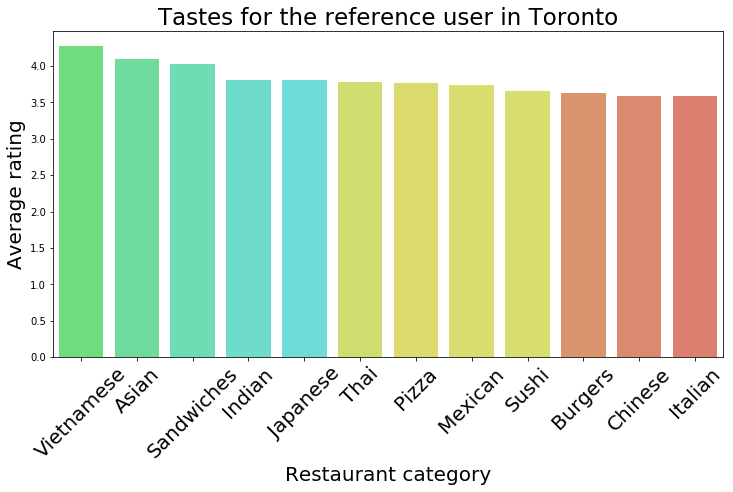

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
x=users_phoenix_a[users_phoenix_a.index=='reference_user'].T.sort_values(by='reference_user',ascending=False)
colors_good = ['#34eb4c', '#34eb83', '#34eba8', '#34ebcd', '#34ebe2', '#d6eb34', '#ebe534','#e5eb34','#e5eb34', '#eb7134','#eb6234', '#eb4f34']
plt.figure(figsize=(12,6))

ax = sns.barplot(x.index, x.reference_user, alpha=0.8, palette=colors_good)
plt.title("Tastes for the reference user in Toronto", fontsize=23)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45,fontsize=20)
plt.ylabel('Average rating', fontsize=20)
plt.xlabel('Restaurant category', fontsize=20)

Now we will focus on find similar users to this reference user, but this time in Phoenix.

We will load the dataset user_phoenix which is a subdataset of user.json from Yelp.

In [36]:
up=pd.read_csv('user_phoenix.csv')

C:\Users\hecto.DESKTOP-ACA6A3T\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2,3,5,6,7,21,27,32,36,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
up=up[['user_id','name_x','review_count_x','yelping_since','useful_x','friends','average_stars','compliment_more']]

In [38]:
up=up.drop_duplicates()

From all the users of Phoenix, we want to make a first filter in order to select those users that have more than 200 friends so if we invite them to the new opening we would maximize the publicity their reviews could have with their friends.

In [39]:

up['Friends_count'] = up['friends'].apply(lambda x: x.count(',')+1)

up.head()

,user_id,name_x,review_count_x,yelping_since,useful_x,friends,average_stars,compliment_more,Friends_count
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",3.57,2,45
4,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",3.84,4,213
28,QG13XBbgHWydzThRBGJtyw,Claire,218,2007-06-04 00:14:10,587,"tnfVwTpuPlR6W2xEAMiqsg, Bd_16T8Dva27lF5LIrUmcQ...",4.10,5,344
29,I_6wY8_RsewziNnKhGZg4g,Jeff,405,2010-08-05 18:42:29,799,"OGa2q6LvuQLYFUG_RCcALw, 0uM2R-uMBemiNlrFG5j56A...",3.63,8,210
33,HwPGLzF_uXB3MF8bc5u5dg,TJ,6,2009-01-02 19:09:32,16,"XEHZoTDWjw3w-gcQyYIe4g, KyeCA8acObsNpgU3fH0W0A...",4.50,1,8


In [40]:
candidates_phoenix=up[up['Friends_count']>200]

In [41]:
up_friends=users_phoenix_a.merge(candidates_phoenix, on='user_id',how='inner')

In [42]:
up_friends=up_friends.set_index('user_id')

In [43]:
up_friends=up_friends.dropna(how='all')

In [44]:
len(up_friends)

1059

In [45]:
up_friends[['Vietnamese','Asian','Thai','Mexican','Italian','Japanese','Chinese','Burgers','Sandwiches','Pizza','Sushi','Indian']]

,Vietnamese,Asian,Thai,Mexican,Italian,Japanese,Chinese,Burgers,Sandwiches,Pizza,Sushi,Indian
user_id,,,,,,,,,,,,
--2HUmLkcNHZp0xw6AMBPg,5.000000,5.000000,5.000000,4.647059,4.545455,NaN,5.000000,4.400000,4.666667,4.363636,5.000000,5.000000
-0Vct02wYX3p4bymSQhl1g,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0aInSHjCWLfiNqfgmWnow,4.250000,4.250000,5.000000,4.000000,4.600000,4.142857,3.571429,3.000000,3.000000,4.333333,4.000000,NaN
-3-j36k_mH2ShcfZic67Ww,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-7DuFiNbBt_KdVdvrjIKeA,5.000000,4.000000,5.000000,4.500000,4.000000,5.000000,NaN,3.750000,3.166667,3.666667,5.000000,NaN
-7Ph0p0vRszjQjyuU1P-_Q,5.000000,5.000000,5.000000,NaN,1.000000,NaN,5.000000,NaN,1.000000,1.000000,NaN,NaN
-AIHeZCFGDc4zqMP-l0VTw,5.000000,NaN,5.000000,5.000000,5.000000,NaN,NaN,NaN,4.500000,4.500000,NaN,NaN
-Biq3Dt8YhkRJEO_ITrvww,5.000000,5.000000,5.000000,4.333333,5.000000,5.000000,5.000000,NaN,5.000000,5.000000,5.000000,NaN
-K_6MMe029REUKUrUGtCxQ,5.000000,5.000000,NaN,NaN,5.000000,3.500000,NaN,NaN,4.500000,5.000000,5.000000,5.000000


Once the dataset is ready, we can plot the correlation matrix to look for the most correlated users in Phoenix with respect to the reference user identified in Toronto.

In [46]:
up_friends = up_friends.append(pd_series)
correlations = up_friends[['Vietnamese','Asian','Thai','Mexican','Italian','Japanese','Chinese','Burgers','Sandwiches','Pizza','Sushi','Indian']].transpose().corr()


In [47]:
K = 100
user_id = 'reference_user'
neighbours_corr = correlations[user_id].sort_values(ascending=False)[1: K+1]
future_customers=neighbours_corr.index.to_list()

In [48]:
potential_customers=neighbours_corr.index.to_list()

In [49]:
neighbours_corr

user_id
wkTTToTV-qTQPw1nYUahGA    1.000000
21h7ET2xN2dHDXvUxYR8Hw    1.000000
5ZKLbiWCvVkV7Qc3LZonyQ    1.000000
5yEq7Z5ux_RNQrbKueLU3A    1.000000
9Ek1WMJcYPkl0ild7eFpDQ    1.000000
B1OVDsstzC_RaESmtd1oWQ    1.000000
FL-YTGSgKQ3QC06DD-Q4Ew    1.000000
IGcz4__MMNigu6c1m1B-gg    1.000000
MKbNJd_onf1rqOY4bPlLFw    1.000000
efA2hee3sgbtFXvSCDs-4g    1.000000
NF5RusR6wSg6KFmyLI5Xwg    1.000000
cU0lbDPDOjf1zk3IFdkjHQ    1.000000
bs9AEsMNuJoI3AJUKQl8bA    1.000000
OWTPETtZUiFiOJb_bqunDQ    1.000000
zwBLEIkfqmtBSJRq8paSXQ    1.000000
zl4RII7FesMnf638WXg4nQ    1.000000
zoOACYF-JDF9YV5vkAkcxQ    1.000000
7WHX4WiEoJyigTjhDkFrIw    0.995454
V1q_I9E4of_31YmUrqepew    0.993188
w0eICejhdGkuYoSrjCyJSA    0.991678
dt-nbGRBU7qheUPbpdyFGQ    0.973435
VucpiBotEQ8iTjuairaVnA    0.973435
oGPJZgeHZDm_oqAXJYP2yw    0.965650
5rf70vnqvROvr4GDvMCP1Q    0.963594
xghoe77Q5SfM0Ah_Mjf5Vw    0.962357
UL31B_Pm8HeJfYKDB7AUww    0.937625
4mkz_SNApQfXX9f6wMZaxg    0.935717
c8uqT8XFFaONsguhJoSoLg    0.923919
X_SK2R_tYyvd

In [50]:
neighbours_corr.mean()

0.8339369688835389

The mean correlation of these 100 useres with the target user in Toronto is 84% which is quite good.

In [51]:
future_customers=up_friends[up_friends.index.isin(potential_customers)][['Vietnamese','Asian','Thai','Mexican','Italian','Japanese','Chinese','Burgers','Sandwiches','Pizza','Sushi','Indian']]


In [52]:
future_customers.to_csv('future_customers.csv')

In [53]:
future_customers.head()

,Vietnamese,Asian,Thai,Mexican,Italian,Japanese,Chinese,Burgers,Sandwiches,Pizza,Sushi,Indian
user_id,,,,,,,,,,,,
-iFWTEPA84DKWBhGww8EeQ,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,4.0
0AP8keIdzR7exbF8lLvufA,5.0,4.0,NaN,NaN,NaN,3.5,3.0,NaN,5.000000,NaN,3.5,NaN
0dmjg1Jf9gvia8rFfCmfnQ,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN
0svRYzDE36FbhfgtqMJj2w,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.5,NaN
0t-O5--DOfS55A620fO_GA,5.0,4.5,NaN,4.0,3.5,3.0,4.0,4.0,4.666667,4.25,3.0,NaN


In [54]:
userf=future_customers.groupby('user_id').agg(agregate)
userf.head()

,Vietnamese,Asian,Thai,Mexican,Italian,Japanese,Chinese,Burgers,Sandwiches,Pizza,Sushi,Indian
user_id,,,,,,,,,,,,
-iFWTEPA84DKWBhGww8EeQ,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,4.0
0AP8keIdzR7exbF8lLvufA,5.0,4.0,NaN,NaN,NaN,3.5,3.0,NaN,5.000000,NaN,3.5,NaN
0dmjg1Jf9gvia8rFfCmfnQ,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN
0svRYzDE36FbhfgtqMJj2w,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.5,NaN
0t-O5--DOfS55A620fO_GA,5.0,4.5,NaN,4.0,3.5,3.0,4.0,4.0,4.666667,4.25,3.0,NaN


In [55]:
future_user=[]
for cat in categories:
    future_user.append(np.nanmean(userf[cat].to_list()))
future_user

[4.985833333333334,
 4.165697674418604,
 3.838,
 3.8803058783321944,
 3.450872574556785,
 3.421119929453263,
 2.915190018315018,
 3.249537195260879,
 4.352975235548764,
 3.548997698997699,
 3.460982410982411,
 3.6597222222222228]

In [56]:
pd_series_t = pd.Series(future_user, index = users_phoenix.columns)
pd_series_t.name='target_user'
users_phoenix_future = future_customers.append(pd_series_t)

In [57]:
users_phoenix_future[users_phoenix_future.index=='target_user']

,Vietnamese,Asian,Thai,Mexican,Italian,Japanese,Chinese,Burgers,Sandwiches,Pizza,Sushi,Indian
user_id,,,,,,,,,,,,
target_user,4.985833,4.165698,3.838,3.880306,3.450873,3.42112,2.91519,3.249537,4.352975,3.548998,3.460982,3.659722


Text(0.5, 0, 'Restaurant category')

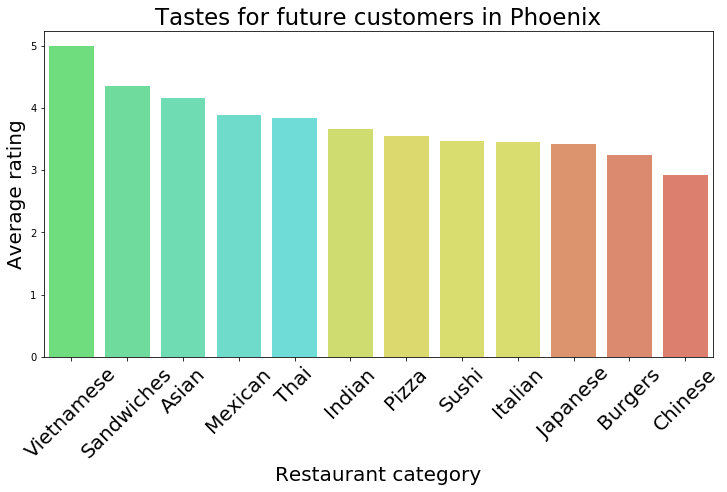

In [58]:
x=users_phoenix_future[users_phoenix_future.index=='target_user'].T.sort_values(by='target_user',ascending=False)
colors_good = ['#34eb4c', '#34eb83', '#34eba8', '#34ebcd', '#34ebe2', '#d6eb34', '#ebe534','#e5eb34','#e5eb34', '#eb7134','#eb6234', '#eb4f34']
plt.figure(figsize=(12,6))

ax = sns.barplot(x.index, x.target_user, alpha=0.8, palette=colors_good)
plt.title("Tastes for future customers in Phoenix", fontsize=23)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45,fontsize=20)
plt.ylabel('Average rating', fontsize=20)
plt.xlabel('Restaurant category', fontsize=20)

We now have now 100 potential customers identified with high probabilities of becoming new loyal customers in Phoenix. Their Tastes Distribution even maximize the main categories of Bahn Mi Boys (Vietnamese, Sandwiches, Asian) over the rest.